In [1]:
# Edit text
# Write TEST functions
# fix sample notebook
# AM TEXT FILE IS ACTUALLY CO
# make py files and remove the plt.show commands
# upload real data files and fix links in makefile

In [5]:
%run ./lab1_analysis_functions.py

In [6]:
tenevents = read_ten_event_file()

M = find_M_value(tenevents)
print('M ', M)

('M ', 4445.9118105773478)


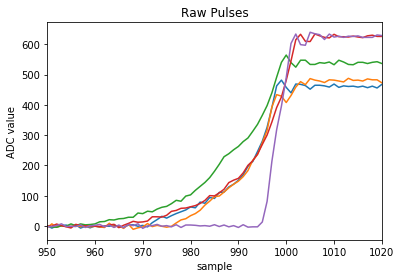

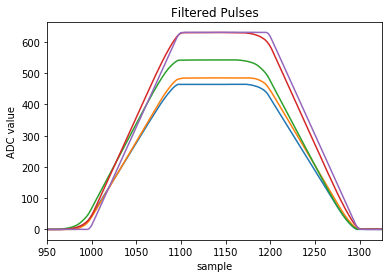

In [7]:
tenevents = read_ten_event_file()
ndata = len(tenevents)
nsamples = 4096
x_values = np.linspace(0, nsamples, nsamples)
tenevents = fast_baseline_correction(tenevents)
plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    plt.plot(event)
plt.xlim([950, 1020])
plt.title('Raw Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_rawdata.pdf')
plt.show()

k = 100
m = 100

plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    event = fast_trapezoidal_filter(event, k, m, M=4400)
    plt.plot(x_values, event)
plt.xlim([950, 1325])
plt.title('Filtered Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_filtered.pdf')
plt.show()

In [5]:
filename = '../data/Am_pulser_real.h5'
am_raw_data = import_data(filename)

filename = '../data/Cs_pulser_real.h5'
cs_raw_data = import_data(filename)

filename = '../data/Co_pulser_real.h5'
co_raw_data = import_data(filename)

In [6]:
cs_baseline = np.mean(cs_raw_data[:len(cs_raw_data),0:799],1).reshape((len(cs_raw_data),1))
cs_baseline_corrected_signals = cs_raw_data[:len(cs_raw_data),] - cs_baseline

In [7]:
# M = find_M_value(cs_baseline_corrected_signals[0:len(cs_raw_data)])
M = 5920.5649833
optimal_M = M
print('optimal M: ', M)

('optimal M: ', 5920.5649833)


In [9]:
# OPTIMIZE GAP TIME

m_values = np.linspace(0, 100, 30)
k = 100

number_of_events = len(cs_raw_data)
#number_of_events = 10000
assert number_of_events <= len(cs_raw_data)
ndata = 4096

m_fwhm_values = []
m_values_ns = []
m_fwhm_values_err = []

for m in m_values:
    m = int(m)
    m_values_ns.append(m * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    nbins = 2048
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512]) #, range=Cs_range) # WORKS
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_fwhm, cs_center, err = fit_gaussian_peak_linear_background(cs_bins[1000:2000], cs_counts[1000:2000])
    m_fwhm_values_err.append(err* 100 / cs_center)
    m_fwhm_values.append(round(cs_fwhm / cs_center, 7) * 100)

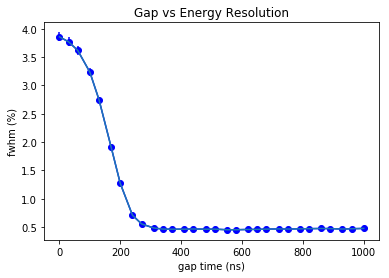

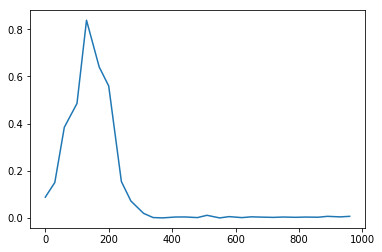

In [10]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(m_values_ns, m_fwhm_values, yerr=m_fwhm_values_err, ecolor='b')
plt.plot(m_values_ns, m_fwhm_values, 'o-b')
plt.title('Gap vs Energy Resolution')
plt.savefig('../figures/gap_optimization_cs.pdf')
plt.show()

In [11]:
optimal_gap_time =  int(m_values_ns[np.argmin(m_fwhm_values)]) / 10
m = optimal_gap_time 
print('optimal gap time: ' + str(m * 10))

optimal gap time: 550


In [12]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 50, endpoint=True, base=10)
number_of_events = len(cs_raw_data)
assert number_of_events <= len(cs_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []
m = 25

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512])
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_bins = cs_bins[1000:2000]
    cs_counts = cs_counts[1000:2000]
   # plt.plot(cs_bins, cs_counts)
   # plt.show()
    cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

    k_fwhm_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
    k_fwhm_values_err.append(err * 100 / cs_peak_center)

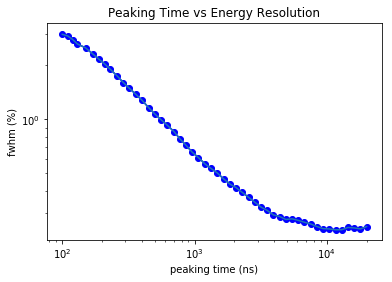

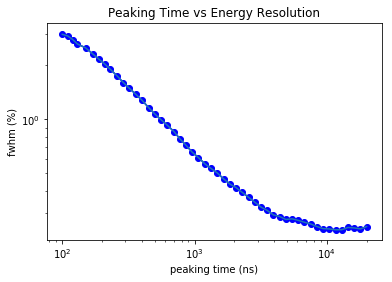

In [14]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.title('Peaking Time vs Energy Resolution')
plt.tick_params(axis='y', which='minor')
plt.savefig('../figures/peak_optimization_cs.pdf')
plt.show()

In [15]:
optimal_peaking_time = k_values_ns[np.argmin(k_fwhm_values)] / 10
k = optimal_peaking_time
print('optimal peaking time:' + str(k * 10))

('optimal peaking time: ', 1164)


In [16]:
# Final Filter Paramters
print("========  Final Filter Parameters  ========")
print(' gap time (m)     = ' + str(m * 10) + ' ns')
print(' peaking time (k) = ' + str(k * 10) + ' ns')
print(' decay time (M)   = ' + str(round(M / 10,2)) + ' ns')
print("===========================================")

save_parameters(m * 10 , k * 10 , M / 10)

========  Final Filter Parameters  ========
 gap time (m)     = 250 ns
 peaking time (k) = 11640 ns
 decay time (M)   = 592.06 ns


In [17]:
cs_baseline = np.mean(cs_raw_data[:len(cs_raw_data),0:799],1).reshape((len(cs_raw_data),1))
cs_baseline_corrected_signals = cs_raw_data[:len(cs_raw_data),] - cs_baseline

am_baseline = np.mean(am_raw_data[:len(am_raw_data),0:799],1).reshape((len(am_raw_data),1))
am_baseline_corrected_signals = am_raw_data[:len(am_raw_data),] - am_baseline

co_baseline = np.mean(co_raw_data[:len(co_raw_data),0:799],1).reshape((len(co_raw_data),1))
co_baseline_corrected_signals = co_raw_data[:len(co_raw_data),] - co_baseline

cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
co_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, co_baseline_corrected_signals, k, m, M)
am_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, am_baseline_corrected_signals, k, m, M)

In [18]:
make_nrg_sample_file(co_nrgs[0:len(co_nrgs)], '../data/co_energies.txt')
make_nrg_sample_file(cs_nrgs[0:len(cs_nrgs)], '../data/cs_energies.txt')
make_nrg_sample_file(am_nrgs[0:len(am_nrgs)], '../data/am_energies.txt')

In [19]:
# GET ENERGY RESOLUTION FOR DIFFERENT PEAKS

fwhm_peak_values = []
fwhm_peak_energies = []
fwhm_pulser_values = []
peak_err = []
pulser_err = []

# AM-241
am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[10:250] 
am_counts = am_counts[10:250]
peak_fwhm, peak_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_peak_values.append(round(peak_fwhm / peak_center, 7) * 100)
fwhm_peak_energies.append(59.536)
peak_err.append(err * 100 / peak_center)

# AM-PULSER

am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[1000:2000] 
am_counts = am_counts[1000:2000]
pulser_fwhm, pulser_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err* 100 / pulser_center)

# CS-662
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0, 512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[1000:2000]
cs_counts = cs_counts[1000:2000]
cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

fwhm_peak_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
fwhm_peak_energies.append(661.615)
peak_err.append(err* 100 / cs_peak_center)

# CS-PULSER
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[900, 900+512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[100:1000]
cs_counts = cs_counts[100:1000]
cs_pulser_fwhm, cs_pulser_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)
fwhm_pulser_values.append(round(cs_pulser_fwhm / cs_pulser_center, 7) * 100)
pulser_err.append(err * 100 / cs_pulser_center)

# CO-1173
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
peak_1_fwhm, peak_1_center, err = fit_gaussian_peak_linear_background(co_bins[1200:1450], co_counts[1200:1450])
fwhm_peak_values.append(round(peak_1_fwhm / peak_1_center, 7) * 100)
fwhm_peak_energies.append(1173.231)
peak_err.append(err * 100 / peak_1_center)

# CO-1332
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1400:1600]
co_counts = co_counts[1400:1600]
peak_2_fwhm, peak_2_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_peak_values.append(round(peak_2_fwhm / peak_2_center, 7) * 100)
fwhm_peak_energies.append(1332.508)
peak_err.append(err * 100/ peak_2_center)

# CO-PULSER
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[512, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1800:] 
co_counts = co_counts[1800:]
pulser_fwhm, pulser_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err * 100/ pulser_center)

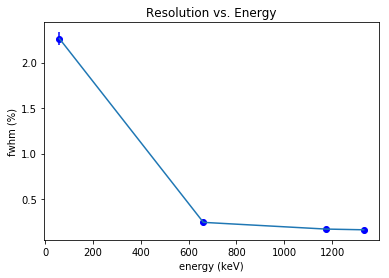

In [20]:
plt.plot(fwhm_peak_energies, fwhm_peak_values, 'ob')
plt.errorbar(fwhm_peak_energies, fwhm_peak_values, yerr=peak_err, ecolor='b')
plt.title('Resolution vs. Energy')
plt.ylabel('fwhm (%)')
plt.xlabel('energy (keV)')
plt.savefig('../figures/fwhm_vs_energy.pdf')
plt.show()

In [27]:
# find fano factor

fano_list = []
fwhm_elec = np.mean(fwhm_pulser_values) # Am-241 pulser value is very differnet. Shouldn't depend on energy. Ignore for now.
for i in range(0, len(fwhm_peak_energies), 1):
    e = fwhm_peak_energies[i]
    fwhm =(fwhm_peak_values[i] / 100) # was a percent
    fwhm = fwhm - (fwhm_elec / 100)
    fwhm = fwhm * fwhm_peak_energies[i] #fwhm in kev
    fano =fwhm * (1/2.35) * np.sqrt(1/(e*(2.9*10**(-3)))) 
    fano = fano**2
    fano = round(fano, 3)
    fano_list.append(fano)
    
fano = round(np.mean(fano_list[1:]),3)
print('average fano factor: ' + str( fano))
print('list of fano factors: ' + str(fano_list[1:]))

average fano factor: 0.039
list of fano factors: [0.072, 0.025, 0.021]


In [22]:
print('ANALYSIS COMPLETE')

ANALYSIS COMPLETE
